In [1]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd

In [2]:
# This code block unzips the full Cats-v-Dogs dataset to /tmp
# which will create a tmp/PetImages directory containing subdirectories
# called 'Cat' and 'Dog' (that's how the original researchers structured it)
path_cats_and_dogs = f"{getcwd()}/../tmp2/cats-and-dogs.zip"
shutil.rmtree('/tmp')

local_zip = path_cats_and_dogs
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [3]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))


1500
1500


In [7]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')

except OSError:
    pass

In [8]:

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files=[]
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + 'is zero length')
    training_size = int(len(files)* SPLIT_SIZE)
    testing_size = int(len(files) - training_size)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_size]
    testing_set = shuffled_set[-testing_size:]
    
    for filename in training_set:
        file = SOURCE + filename
        dest = TRAINING + filename
        copyfile(file, dest)
    
    for filename in testing_set:
        file = SOURCE + filename
        dest = TESTING + filename
        copyfile(file, dest)

CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [9]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))


1350
1350
150
150


In [11]:
# DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
# 3 CONVOLUTION LAYERS
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')    
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [13]:
TRAINING_DIR = '/tmp/cats-v-dogs/training'
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size = 10,
                                                    class_mode = 'binary',
                                                    target_size=(150,150))

VALIDATION_DIR = '/tmp/cats-v-dogs/testing'
validation_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                    batch_size = 10,
                                                    class_mode = 'binary',
                                                    target_size=(150,150))


Found 2700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [15]:
history = model.fit_generator(train_generator,
                              epochs=5,
                              verbose=1,
                              validation_data=validation_generator)


Epoch 1/5
270/270 [==============================] - 63s 233ms/step - loss: 0.6302 - acc: 0.6489 - val_loss: 0.8038 - val_acc: 0.5433
Epoch 2/5
270/270 [==============================] - 62s 231ms/step - loss: 0.6456 - acc: 0.6452 - val_loss: 0.6079 - val_acc: 0.6567
Epoch 3/5
270/270 [==============================] - 63s 234ms/step - loss: 0.6183 - acc: 0.6641 - val_loss: 0.5853 - val_acc: 0.7067
Epoch 4/5
270/270 [==============================] - 61s 227ms/step - loss: 0.6190 - acc: 0.6700 - val_loss: 0.5606 - val_acc: 0.7400
Epoch 5/5
270/270 [==============================] - 57s 211ms/step - loss: 0.6057 - acc: 0.6837 - val_loss: 0.6941 - val_acc: 0.6667


Text(0.5, 1.0, 'Training and validation loss')

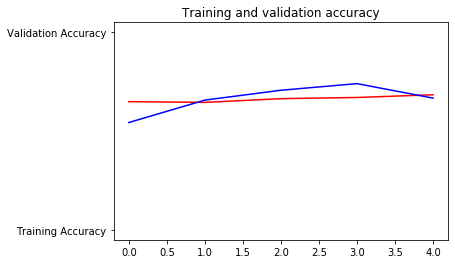

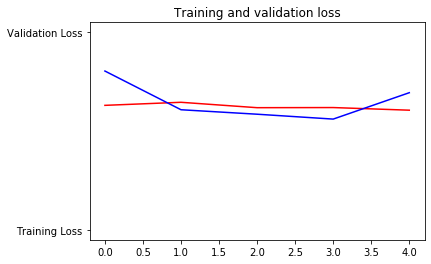

In [16]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")

plt.title('Training and validation loss')